# CSE 291 Assignment 2 BiLSTM CRF

## Download Data/Eval Script

In [ ]:
!wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
!wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/dev.data.quad

In [ ]:
import conlleval
from tqdm import tqdm
import numpy as np
from collections import defaultdict, Counter
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import Vocab
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

torch.manual_seed(291)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

## Data Preparation

In [ ]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield sent[0], sent[1]
                sent = [[], []]


def prepare_dataset(dataset, word_vocab, label_vocab):
    dataset = [
      [
        torch.tensor([word_vocab.stoi[word] for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab.stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])
word_vocab = Vocab(train_word_counter, specials=(UNK, PAD), min_freq=2)
label_vocab = Vocab(train_label_counter, specials=(), min_freq=1)
train_data = prepare_dataset(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.stoi.keys())}')
valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

print(' '.join([word_vocab.itos[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in train_data[0][1]]))

print(' '.join([word_vocab.itos[i.item()] for i in valid_data[1][0]]))
print(' '.join([label_vocab.itos[i.item()] for i in valid_data[1][1]]))

## BiLSTMTagger

In [ ]:
# Starter code implementing a BiLSTM Tagger
# which makes locally normalized, independent
# tag classifications at each time step

class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTMTagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device)
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence))
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out
        bilstm_feats = self.tag_projection_layer(bilstm_out)
        return bilstm_feats

    def forward(self, sentence):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        return bilstm_feats.max(-1)[0].sum(), bilstm_feats.argmax(-1)

    def loss(self, sentence, tags):
        bilstm_feats = self.compute_lstm_emission_features(sentence)
        # transform predictions to (n_examples, n_classes) and ground truth to (n_examples)
        return torch.nn.functional.cross_entropy(
              bilstm_feats.view(-1, self.tagset_size), 
              tags.view(-1), 
              reduction='sum'
            )

## Train / Eval loop

In [43]:
def train(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    losses_per_epoch = []
    F1_scores=[]
    lossavg=[]
    valid_loss=[]
    for epoch in range(epochs):
        print(f'--- EPOCH {epoch} ---')
        model.train()
        losses_per_epoch.append([])
        for i, (sent, tags) in enumerate(train_data):
            model.zero_grad()
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            loss = model.loss(sent, tags)
            loss.backward()
            optimizer.step()

            losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                print(f'Avg loss over last {log_interval} updates: {np.mean(losses_per_epoch[-1][-log_interval:])}')

        k, li=evaluate(model, valid_data, word_vocab, label_vocab)
        F1_scores.append(k)
        print(F1_scores)
        sum=0
        for i in losses_per_epoch[-1]:
            sum+=i
        sum=sum/len(losses_per_epoch[-1])
        lossavg.append(sum)
        print(lossavg)
        valid_loss.append(li)
    return F1_scores, lossavg, valid_loss

def evaluate(model, dataset, word_vocab, label_vocab):
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            losses.append(model.loss(sent, tags).cpu().detach().item())
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab.itos[i] for i in tags.tolist()[0]])
            pred_tags.append([label_vocab.itos[i] for i in pred_tag_seq[0]])
            sents.append([word_vocab.itos[i] for i in sent[0]])

    print('Avg evaluation loss:', np.mean(losses))
    F1=conlleval.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True)
    print(F1)
    print('\n5 random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=5):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return F1[2], np.mean(losses)

## Training

In [44]:
# Train BiLSTM Tagger Baseline
model = BiLSTMTagger(len(word_vocab), len(label_vocab), 128, 256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
F1_scores, losses, l=train(model, train_data, valid_data, word_vocab, label_vocab, epochs=30, log_interval=500)
print(F1_scores)

--- EPOCH 0 ---
Avg loss over last 500 updates: 9.391260840058326
Avg loss over last 500 updates: 8.20831001725793
Avg loss over last 500 updates: 6.45184474748373
Avg loss over last 500 updates: 5.7952213330389934
Avg loss over last 500 updates: 4.942988632818684
Avg loss over last 500 updates: 5.009902286473895
Avg evaluation loss: 4.660058935804773
processed 11170 tokens with 1231 phrases; found: 823 phrases; correct: 499.
accuracy:  47.30%; (non-O)
accuracy:  89.68%; precision:  60.63%; recall:  40.54%; FB1:  48.59
              LOC: precision:  76.38%; recall:  41.87%; FB1:  54.09  199
             MISC: precision:  62.86%; recall:  22.92%; FB1:  33.59  70
              ORG: precision:  56.11%; recall:  40.39%; FB1:  46.97  221
              PER: precision:  53.75%; recall:  48.51%; FB1:  51.00  333
(60.631834750911295, 40.53614947197401, 48.58812074001948)

5 random evaluation samples:
SENT: JOHANNESBURG 1996-08-26
TRUE: I-LOC O
PRED: O O
SENT: " Three of the four children had <u

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] [6.389373369815946, 3.896263542489296, 2.9172058588735195, 2.292429349753741, 2.0017210450249934, 1.7214541443771276, 1.5328994430464045, 1.4003152169364792, 1.2895168202189515, 1.1761747294513527, 1.0332564692092077, 0.9559578708484299, 0.9442425611332074, 0.8751629874491367, 0.8542976397599217, 0.780340942745662, 0.7499144351607289, 0.7288407253762079, 0.7000037979311204, 0.6188072329577506, 0.6022002787322669, 0.5629189788287869, 0.6023973730222353, 0.5638683039109181, 0.5354457257899743, 0.5288881765682273, 0.5157631192699076, 0.48112713399429025, 0.4782464094798824, 0.47952119598771575]


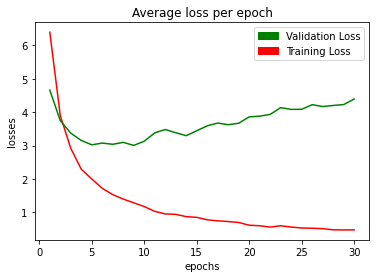

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30] [48.58812074001948, 59.1726618705036, 63.83928571428572, 65.61679790026245, 67.27037516170763, 67.76572668112799, 68.8026981450253, 68.8135593220339, 69.38261234775304, 70.56313993174061, 70.72758037225043, 69.79975480179812, 70.7808564231738, 71.61825726141079, 70.55879899916596, 71.65551839464884, 70.6508391322145, 70.56883759274525, 70.51495016611297, 72.46256239600665, 71.42268041237114, 70.05282405526209, 71.31589871315899, 70.96241222635275, 70.92547092547092, 71.60596026490066, 71.76759410801964, 71.47022074135776, 70.26359143327842, 71.44622991347343]


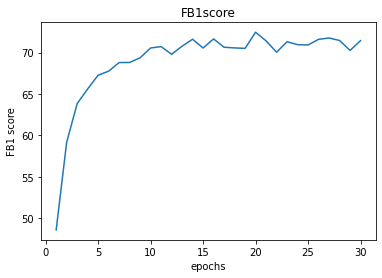

In [48]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
x, y=[], []
count=0 
# x axis values
for i in (losses):
    count+=1
    y.append(count)
    x.append(i)
print(y,x)

  
# plotting the points 
plt.plot(y,x, color='red')
plt.plot(y,l, color='green')
  
# naming the x axis
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('losses')
  
# giving a title to my graph
plt.title("Average loss per epoch")
red_patch = mpatches.Patch(color='red', label='Training Loss')

g_patch = mpatches.Patch(color='green', label='Validation Loss')
plt.legend(handles=[g_patch, red_patch])
# function to show the plot
plt.show()
#-----------------------------------------------------------------------
x, y=[], []
count=0 
# x axis values
for i in (F1_scores):
    count+=1
    y.append(count)
    x.append(i)
print(y,x)

  
# plotting the points 
plt.plot(y,x)
  
# naming the x axis
plt.xlabel('epochs')
# naming the y axis
plt.ylabel('FB1 score')
  
# giving a title to my graph
plt.title("FB1score")
  
# function to show the plot
plt.show()


In [1]:
print(max(F1_scores))

NameError: ignored